In [1]:
!pip install rasterio
!pip install ipdb
!pip install torchinfo
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15

In [2]:

file_id = "1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ"
output_file = "downloaded_file.zip"

!gdown --id $file_id -O $output_file

print(f"File {output_file} downloaded successfully!")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ
From (redirected): https://drive.google.com/uc?id=1ODRghvcRWp9WabC34dh11Cd0iHw0bamJ&confirm=t&uuid=9291cf37-4613-427e-b34d-9fa764e01270
To: /content/downloaded_file.zip
100% 4.93G/4.93G [01:18<00:00, 63.1MB/s]
File downloaded_file.zip downloaded successfully!


In [3]:
import os
import ipdb
# Create a folder to extract the files

extract_path = "/content/extracted_files"
PathToGeoTiffFile = os.path.join(extract_path, 'Potsdam-GeoTif')

In [4]:
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
!unzip -q "$output_file" -d "$extract_path"

print(f"File extracted to {extract_path}")


File extracted to /content/extracted_files


In [5]:
import shutil
import numpy as np

def extract_xy(filename,splitter='-'):
    """Extracts (x, y) coordinates from filename of format 'x_y.ext'."""
    name, _ = os.path.splitext(filename)
    try:
        x, y = map(int, name.split(splitter))
        return x, y
    except ValueError:
        return None  # Skip if filename is not in expected format

def create_sorted_grid_map(image_dir):
    """
    Sorts images into a grid-like structure based on their filename coordinates.
    Applies a checkerboard pattern based on the new grid positions.

    Args:
        image_dir (str): Directory containing images.

    Returns:
        list: List of (filename, grid_x, grid_y)
    """
    # Get all images with (x, y) extracted
    image_files=os.listdir(image_dir)
    images = [(f, extract_xy(f)) for f in image_files]

    images = [(f, xy) for f, xy in images if xy is not None]  # Remove invalid filenames

    # Sort by x first, then by y
    images.sort(key=lambda item: (item[1][0], item[1][1]))

    # Assign new grid coordinates
    grid_map = []
    grid_x, grid_y = 0, 0
    last_x = None
    for filename, (x, y) in images:
        if last_x is None or x != last_x:
            grid_x += 1  # Move to next row in the grid
            grid_y = 0  # Reset column index
        grid_map.append((filename, grid_x, grid_y))
        grid_y += 1
        last_x = x

    return grid_map

def split_checkerboard(image_dir,train_folder="train", test_folder="test", square_size=1):
    """
    Moves files into train/test folders using a checkerboard pattern on the sorted grid map.

    Args:
        image_dir (str): Source directory of images.
        train_dir (str): Directory to move training images.
        test_dir (str): Directory to move testing images.
        square_size (int): Width of each checkerboard square.
    """
    os.makedirs(image_dir, exist_ok=True)
    train_dir = os.path.join(image_dir, train_folder)
    test_dir = os.path.join(image_dir, test_folder)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get sorted grid mapping
    grid_map = create_sorted_grid_map(image_dir)
    #print(f"Grid map created with {len(grid_map)} images.")

    for filename, grid_x, grid_y in grid_map:
      if filename.endswith((".tif")):
       try:
        # Apply checkerboard pattern
        is_train = ((grid_x // square_size) + (grid_y // square_size)) % 2 == 0
        target_dir = train_dir if is_train else test_dir
        shutil.move(os.path.join(image_dir, filename), os.path.join(target_dir, filename))
       except ValueError:
        print(f"Skipping {filename} (invalid format)")
        pass  # Ignore files that don't follow the naming convention

    print(f"Data split complete! Train images: {len(os.listdir(train_dir))}, Test images: {len(os.listdir(test_dir))}")


split_checkerboard(image_dir=PathToGeoTiffFile)
train_data_dir=os.path.join(PathToGeoTiffFile,'train')
test_data_dir=os.path.join(PathToGeoTiffFile,'test')
default_image = os.path.join(train_data_dir,os.listdir(train_data_dir)[2])

Data split complete! Train images: 7529, Test images: 7519


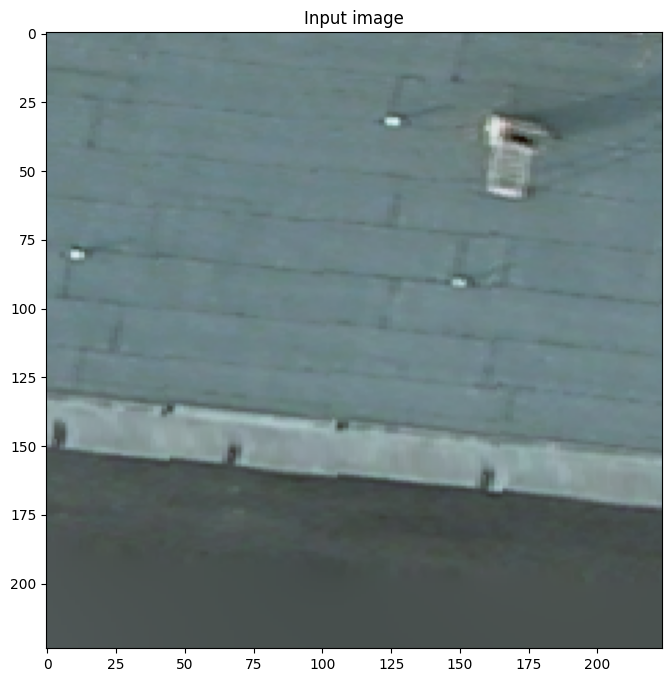

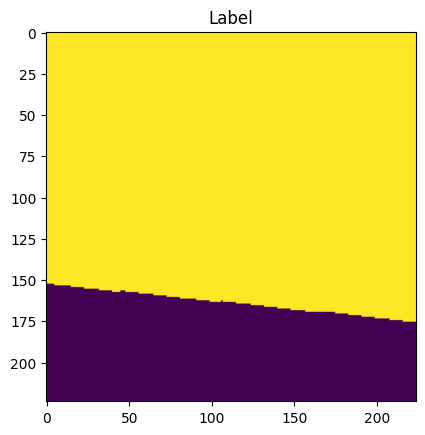

In [6]:
import rasterio as rio
import matplotlib.pyplot as plt

img = rio.open(default_image)
img_array = img.read()
imtransform = img.transform
nRows = img_array.shape[1]
ncols = img_array.shape[2]
Bands = img_array.shape[0]

img_array = img_array.reshape(Bands, nRows*ncols).T
img_array = img_array.reshape( nRows,ncols, Bands)

plt.figure(figsize=(24,8))

plt.imshow(img_array[:,:,0:3]/255)
plt.title('Input image')
plt.show()
plt.imshow(img_array[:,:,5]/255)
plt.title('Label')
plt.show()

In [7]:
from rasterio.transform import xy

with rio.open(default_image) as dataset:
    width, height = dataset.width, dataset.height
    print("width: ",width)
    print("height: ",height)
    center_x = width // 2
    center_y = height // 2
    lon, lat = xy(dataset.transform, center_y, center_x)

print(f"Center Longitude: {lon}, Center Latitude: {lat}")


width:  224
height:  224
Center Longitude: 13.042219423157187, Center Latitude: 52.39704955021628


In [8]:
import random
import torch
import numpy as np

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(f'Using device: {device}')

if device.type == 'cuda':
    batch_size = 200
else:
    batch_size = 16

# Set random seed for reproducibility
def set_seed(seed=2024):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(2024)

Using device: cuda


In [9]:
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class GeoTiffDataset(Dataset):
    def __init__(self, image_dir, default_image, transform=None, sample_size=None):

        self.default_image=default_image
        # Collect all image paths
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')]

        # If sample_size is provided, randomly select that many samples
        if sample_size:
            self.image_paths = random.sample(self.image_paths, min(sample_size, len(self.image_paths)))

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image=None

        try:
            with rio.open(img_path) as src:
                image = src.read()  # (Bands, Height, Width)
                src.close()

        except rio.errors.RasterioIOError as e:
            print(f"Error reading {img_path}: {e}")
            # Handle the error by returning a default image and label
            # Use zeros for both image and label or skip this entry
            with rio.open(self.default_image) as src:
                image = src.read()
                src.close()


        # Split features (X) and labels (y)
        X = image[:4, :, :]  # First 4 bands (Red, Green, Blue, IR)
        X = X.astype(np.float32) / np.max(X)
        y = image[5, :, :]  # 6th band (Segmentation mask or labels
        # Apply transformations (only to X)
        if self.transform:
            X = self.transform(X)
        # Convert X back to (C, H, W) and y to tensor
        X = torch.tensor(X)  # .permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        y = torch.tensor(y, dtype=torch.long)  # Convert labels to tensor

        return X, y



# Define transformations for input images
# Normalzing is a good idea as it
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x)), # Convert to tensor using Lambda
    transforms.Normalize(mean=[0.5] * 4, std=[0.5] * 4)  # Normalize 4 bands
])

# Load Dataset
dataset = GeoTiffDataset(train_data_dir, default_image=default_image, transform=transform,sample_size=None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_shape=None
# Example: Iterate through DataLoader
for X_batch, y_batch in dataloader:
    input_shape=X_batch.shape
    print(X_batch.shape, y_batch.shape)
    labels=np.unique(y_batch)
    print("labels: ",labels)
    # Expected output: (16, 5, 224, 224) for inputs, (16, 224, 224) for labels
    break

<ipython-input-9-132741d1706b>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)  # .permute(2, 0, 1)  # (H, W, C) → (C, H, W)


torch.Size([200, 4, 224, 224]) torch.Size([200, 224, 224])
labels:  [0 1 2 3 4 5]


In [10]:
import torch.nn as nn
import torch.optim as optim

# Default join operation (concatenation)
def join_operation(x, skip):
    return torch.cat([x, skip], dim=1)  # Concatenation along channel dimension

# Encoder-Decoder architecture
class EncoderDecoder(nn.Module):
    def __init__(self, input_shape, filter_sizes, kernel_size=3, conv_factor=1, pool_size=2, pool_stride=2, decode=False,
                 conv_layer=nn.Conv2d, pool_layer=nn.MaxPool2d, activation_layer=nn.ReLU,
                 upsample_layer=nn.ConvTranspose2d, padding_mode='zeros', padding=1, join_operation=join_operation):
        super(EncoderDecoder, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.hook_handles = []
        self.output_shapes = []
        self.decode = decode
        self.join_operation = join_operation

        def hook_fn(module, input, output):
            print(f"{module.__class__.__name__}: {output.shape}")
            self.output_shapes.append(output.shape)

        # Encoder
        output_shape = input_shape
        for i in range(len(filter_sizes)):
            for j in range(conv_factor):
                if i == 0 and j == 0:
                    conv_block = nn.Sequential(
                        conv_layer(input_shape[1], filter_sizes[i], kernel_size=kernel_size,
                                   padding=padding, padding_mode=padding_mode),
                        activation_layer()
                    )
                else:
                    conv_block = nn.Sequential(
                        conv_layer(output_shape[1], filter_sizes[i], kernel_size=kernel_size,
                                   padding=padding, padding_mode=padding_mode),
                        activation_layer()
                    )

                output_shape = (output_shape[0], filter_sizes[i], output_shape[2], output_shape[3])
                conv_block.add_module(str(len(conv_block)), pool_layer(kernel_size=pool_size, stride=pool_stride))

            self.encoder_blocks.append(conv_block)

        # Decoder
        if self.decode:
            decoder_channels = self._detect_decoder_channels(filter_sizes)
            for i in range(len(decoder_channels) - 1):
                in_channels = decoder_channels[i]
                out_channels = decoder_channels[i + 1]

                deconv_block = nn.Sequential(
                    upsample_layer(in_channels, out_channels, kernel_size=kernel_size, stride=pool_stride, padding=padding),
                    activation_layer()
                )
                self.decoder_blocks.append(deconv_block)

        # Register hooks
        blocks = [*self.encoder_blocks, *self.decoder_blocks]
        for block in blocks:
            for layer in block.children():
                self.hook_handles.append(layer.register_forward_hook(hook_fn))

    def _detect_decoder_channels(self, filter_sizes):
        """
        Detects the number of channels for the decoder based on the join function.
        """
        decoder_channels = filter_sizes[::-1]  # Reverse the encoder filters for decoder
        detected_channels = []

        # Start with last encoder filter
        x_channels = decoder_channels[0]
        for skip_channels in decoder_channels[1:]:
            dummy_x = torch.randn(1, x_channels, 8, 8)  # Example upsampled feature map
            dummy_skip = torch.randn(1, skip_channels, 8, 8)  # Corresponding skip connection

            joined = self.join_operation(dummy_x, dummy_skip)  # Apply skip function

            detected_channels.append(x_channels)  # Store current channels
            x_channels = joined.shape[1]  # Update x_channels with new output shape

        detected_channels.append(x_channels)  # Final output shape after all joins
        return detected_channels

    def forward(self, x):
        enc_outputs = []
        for block in self.encoder_blocks:
            x = block(x)
            enc_outputs.append(x)

        if self.decode:
            for i, block in enumerate(self.decoder_blocks):
                x = block(x)

                # Ensure spatial dimensions match
                if i < len(enc_outputs) - 1:
                    skip = enc_outputs[-(i + 2)]

                    # Ensure channel dimensions match
                    if x.shape[1] != skip.shape[1]:
                        channel_adjust = nn.Conv2d(x.shape[1], skip.shape[1], kernel_size=1, stride=1, bias=False).to(x.device)
                        x = channel_adjust(x)

                    # Ensure height and width match
                    if x.shape[2:] != skip.shape[2:]:
                        x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)

                    # Perform skip connection using join function
                    x = self.join_operation(x, skip)

        if x.shape[1] == 1:  # If there's only one channel, remove it
            return x.squeeze(1)  # (N, 1, H, W) → (N, H, W)

        return x

    def unhook(self):
        # Remove all the hooks
        for hook in self.hook_handles:
            hook.remove()


cnn_filter_sizes = [32, 6]
encoder_decoder_filter_sizes=[32,64]

# Create model and move to device
cnn_model = EncoderDecoder(input_shape=input_shape, pool_layer=nn.Identity,filter_sizes=cnn_filter_sizes).to(device)

print("cnn_model")
output=cnn_model(torch.randn(input_shape).to(device))
print(output.shape)
cnn_model.unhook()

cnn_model
Conv2d: torch.Size([200, 32, 224, 224])
ReLU: torch.Size([200, 32, 224, 224])
Identity: torch.Size([200, 32, 224, 224])
Conv2d: torch.Size([200, 6, 224, 224])
ReLU: torch.Size([200, 6, 224, 224])
Identity: torch.Size([200, 6, 224, 224])
torch.Size([200, 6, 224, 224])


In [11]:
cnn_model=cnn_model.to(device)
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01, weight_decay=0.0005)

In [13]:
import os
import time
from google.colab import drive

# Mount Google Drive
mount_dir = '/content/drive'
drive.mount(mount_dir)

# Path to save the model
cnn_dir= mount_dir + '/MyDrive/'
cnn_model_name = 'cnn_model'

Mounted at /content/drive


In [23]:
from sklearn.model_selection import KFold
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold
import  json
patience = 5  # For early stopping
num_epochs = 20

def mean_iou(preds, targets):
    num_classes = preds.shape[1]  # Get number of classes from channels
    preds = torch.argmax(preds, dim=1)  # Convert logits to class indices
    ious = []

    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum() - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)  # Smooth to avoid division by zero
        ious.append(iou)

    return sum(ious) / num_classes  # Mean IoU

def save_results(results, results_path):
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

def load_results(results_path):
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            return json.load(f)
    return None

def train_model_with_kfold(model, model_dir, model_name, dataset, criterion, optimizer, device, num_epochs, patience, batch_size, k=5, verbose=True, accuracy_fn=mean_iou):
    # Create model directory
    model_dir = os.path.join(model_dir,model_name)
    os.makedirs(model_dir, exist_ok=True)

    save_path = os.path.join(model_dir, f"{model_name}_best_overall.pt")
    results_path = os.path.join(model_dir, "results.json")

    # Load previous results if available
    previous_results = load_results(results_path)
    results = previous_results if previous_results else {
        'folds': {},
        'last_fold': 0,
        'best_overall_val_acc': 0.0,
        'best_overall_fold': None
    }

    kf = KFold(n_splits=k, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), start=1):
        if fold <= results.get('last_fold', 0):
            continue  # Skip already completed folds

        print(f"Fold {fold}/{k}")
        fold_model_path = os.path.join(model_dir, f"{model_name}_fold{fold}.pt")

        results['folds'][str(fold)] = results['folds'].get(str(fold), {
            'train_acc': [],
            'train_loss': [],
            'val_acc': [],
            'completed_epochs': 0,
            'best_val_acc': 0.0  # Track best val accuracy per fold
        })
        best_val_acc_per_fold = results['folds'][str(fold)]['best_val_acc']

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model.apply(reset_weights)
        epochs_no_improve = 0  # Reset early stopping for this fold

        for epoch in range(results['folds'][str(fold)]['completed_epochs'], num_epochs):
            model.train()
            running_loss, total_train, correct_train = 0.0, 0, 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Fold {fold})", leave=False):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                acc = accuracy_fn(outputs, labels)
                correct_train += acc.item() * labels.size(0)
                total_train += labels.size(0)

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct_train / total_train
            results['folds'][str(fold)]['train_acc'].append(epoch_acc)
            results['folds'][str(fold)]['train_loss'].append(epoch_loss)

            model.eval()
            total_val, correct_val = 0, 0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f"Validation (Fold {fold})", leave=False):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    val_acc = accuracy_fn(outputs, labels)
                    correct_val += val_acc.item() * labels.size(0)
                    total_val += labels.size(0)

            val_acc = 100 * correct_val / total_val
            results['folds'][str(fold)]['val_acc'].append(val_acc)
            results['folds'][str(fold)]['completed_epochs'] = epoch + 1

            if verbose:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%')

            if val_acc > best_val_acc_per_fold:
                best_val_acc_per_fold = val_acc
                results['folds'][str(fold)]['best_val_acc'] = best_val_acc_per_fold
                torch.save(model.state_dict(), fold_model_path)
                if verbose:
                    print(f'New best model for Fold {fold} saved with Val Acc: {best_val_acc_per_fold:.2f}%')
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered for Fold {fold}!")
                    break

            save_results(results, results_path)  # Save after each epoch

        results['last_fold'] = fold
        save_results(results, results_path)  # Save after each fold

        # Update best overall model if this fold outperformed previous best
        if best_val_acc_per_fold > results['best_overall_val_acc']:
            results['best_overall_val_acc'] = best_val_acc_per_fold
            results['best_overall_fold'] = fold
            torch.save(model.state_dict(), save_path)
            if verbose:
             print(f'New overall best model saved from Fold {fold} with Val Acc: {best_val_acc_per_fold:.2f}%')

    return results

# A utility function to reset model weights
def reset_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

train_ratio=0.8
# Define the sizes for each subset (80% train, 10% val, 10% test)
train_size = int(train_ratio* len(dataset))
print(train_size)
# val_size = int((1-train_ratio)/2 * len(dataset))
# print(val_size)
test_size = len(dataset) - train_size  # Ensure total sum is 100%
print(test_size)

# Split the dataset into train, val, and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for each subset
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterate through the training DataLoader
# for X_batch, y_batch in train_loader:
#     print(X_batch.shape, y_batch.shape)
#     break  # Remove this line to iterate through the whole dataset


results = train_model_with_kfold(
    k=5,
    batch_size=batch_size,
    model=cnn_model,
    model_dir=cnn_dir,
    model_name=cnn_model_name,
    dataset=train_dataset,
 #   test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience,
    verbose=True
)

print(results)

6023
1506
Fold 1/5


Epoch 1/20 (Fold 1):   0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-9-132741d1706b>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)  # .permute(2, 0, 1)  # (H, W, C) → (C, H, W)


Epoch [1/20], Loss: 1.4232, Train Acc: 13.79%, Val Acc: 19.22%
New best model for Fold 1 saved with Val Acc: 19.22%


Epoch [2/20], Loss: 1.1725, Train Acc: 22.79%, Val Acc: 23.29%
New best model for Fold 1 saved with Val Acc: 23.29%


Epoch [3/20], Loss: 1.1256, Train Acc: 24.20%, Val Acc: 24.39%
New best model for Fold 1 saved with Val Acc: 24.39%


Epoch [4/20], Loss: 1.0852, Train Acc: 24.78%, Val Acc: 26.63%
New best model for Fold 1 saved with Val Acc: 26.63%


Epoch [5/20], Loss: 1.0868, Train Acc: 24.99%, Val Acc: 26.73%
New best model for Fold 1 saved with Val Acc: 26.73%


Epoch [6/20], Loss: 1.0767, Train Acc: 25.18%, Val Acc: 23.27%


Epoch [7/20], Loss: 1.0639, Train Acc: 25.56%, Val Acc: 24.75%


Epoch [8/20], Loss: 1.0621, Train Acc: 26.20%, Val Acc: 26.73%


Epoch [9/20], Loss: 1.0470, Train Acc: 26.91%, Val Acc: 26.21%


Epoch [10/20], Loss: 1.0433, Train Acc: 27.38%, Val Acc: 24.87%
Early stopping triggered for Fold 1!
New overall best model saved from Fold 1 with Val Acc: 26.73%
Fold 2/5


Epoch [1/20], Loss: 1.6333, Train Acc: 12.14%, Val Acc: 17.95%
New best model for Fold 2 saved with Val Acc: 17.95%


Epoch [2/20], Loss: 1.4574, Train Acc: 18.91%, Val Acc: 19.46%
New best model for Fold 2 saved with Val Acc: 19.46%


Epoch [3/20], Loss: 1.3900, Train Acc: 20.99%, Val Acc: 21.12%
New best model for Fold 2 saved with Val Acc: 21.12%


Epoch [4/20], Loss: 1.3859, Train Acc: 21.33%, Val Acc: 22.98%
New best model for Fold 2 saved with Val Acc: 22.98%


Epoch [5/20], Loss: 1.3668, Train Acc: 21.89%, Val Acc: 22.11%


Epoch [6/20], Loss: 1.3534, Train Acc: 21.80%, Val Acc: 20.85%


Epoch [7/20], Loss: 1.3090, Train Acc: 21.97%, Val Acc: 25.49%
New best model for Fold 2 saved with Val Acc: 25.49%


Epoch [8/20], Loss: 1.0838, Train Acc: 25.67%, Val Acc: 25.06%


Epoch [9/20], Loss: 1.0623, Train Acc: 25.95%, Val Acc: 23.78%


Epoch [10/20], Loss: 1.0573, Train Acc: 26.40%, Val Acc: 24.78%


Epoch [11/20], Loss: 1.0461, Train Acc: 26.86%, Val Acc: 25.57%
New best model for Fold 2 saved with Val Acc: 25.57%


Epoch [12/20], Loss: 1.0406, Train Acc: 27.39%, Val Acc: 26.45%
New best model for Fold 2 saved with Val Acc: 26.45%


Epoch [13/20], Loss: 1.0517, Train Acc: 27.94%, Val Acc: 26.33%


Epoch [14/20], Loss: 1.0443, Train Acc: 27.88%, Val Acc: 27.42%
New best model for Fold 2 saved with Val Acc: 27.42%


Epoch [15/20], Loss: 1.0396, Train Acc: 28.03%, Val Acc: 28.17%
New best model for Fold 2 saved with Val Acc: 28.17%


Epoch [16/20], Loss: 1.0283, Train Acc: 28.61%, Val Acc: 26.52%


Epoch [17/20], Loss: 1.0322, Train Acc: 28.23%, Val Acc: 26.88%


Epoch [18/20], Loss: 1.0217, Train Acc: 28.33%, Val Acc: 27.09%


Epoch [19/20], Loss: 1.0252, Train Acc: 28.50%, Val Acc: 29.62%
New best model for Fold 2 saved with Val Acc: 29.62%


Epoch [20/20], Loss: 1.0215, Train Acc: 28.66%, Val Acc: 29.64%
New best model for Fold 2 saved with Val Acc: 29.64%
New overall best model saved from Fold 2 with Val Acc: 29.64%
Fold 3/5


Epoch [1/20], Loss: 1.5685, Train Acc: 12.71%, Val Acc: 19.79%
New best model for Fold 3 saved with Val Acc: 19.79%


Epoch [2/20], Loss: 1.2137, Train Acc: 22.46%, Val Acc: 22.85%
New best model for Fold 3 saved with Val Acc: 22.85%


Epoch [3/20], Loss: 1.1412, Train Acc: 23.56%, Val Acc: 23.63%
New best model for Fold 3 saved with Val Acc: 23.63%


Epoch [4/20], Loss: 1.1064, Train Acc: 24.44%, Val Acc: 24.23%
New best model for Fold 3 saved with Val Acc: 24.23%


Epoch [5/20], Loss: 1.0905, Train Acc: 24.64%, Val Acc: 23.74%


Epoch [6/20], Loss: 1.0859, Train Acc: 24.59%, Val Acc: 23.57%


Epoch [7/20], Loss: 1.0813, Train Acc: 24.87%, Val Acc: 26.57%
New best model for Fold 3 saved with Val Acc: 26.57%


Epoch [8/20], Loss: 1.0717, Train Acc: 25.83%, Val Acc: 27.11%
New best model for Fold 3 saved with Val Acc: 27.11%


Epoch [9/20], Loss: 1.0592, Train Acc: 26.38%, Val Acc: 28.14%
New best model for Fold 3 saved with Val Acc: 28.14%


Epoch [10/20], Loss: 1.0625, Train Acc: 26.89%, Val Acc: 25.90%


Epoch [11/20], Loss: 1.0620, Train Acc: 26.59%, Val Acc: 26.21%


Epoch [12/20], Loss: 1.0753, Train Acc: 26.90%, Val Acc: 27.36%


Epoch [13/20], Loss: 1.0527, Train Acc: 27.03%, Val Acc: 28.77%
New best model for Fold 3 saved with Val Acc: 28.77%


Epoch [14/20], Loss: 1.0558, Train Acc: 27.10%, Val Acc: 26.53%


Epoch [15/20], Loss: 1.0530, Train Acc: 27.28%, Val Acc: 25.46%


Epoch [16/20], Loss: 1.0494, Train Acc: 27.02%, Val Acc: 27.36%


Epoch [17/20], Loss: 1.0437, Train Acc: 27.15%, Val Acc: 28.50%


Epoch [18/20], Loss: 1.0336, Train Acc: 27.70%, Val Acc: 27.27%
Early stopping triggered for Fold 3!
Fold 4/5


Epoch [1/20], Loss: 1.3913, Train Acc: 16.36%, Val Acc: 23.56%
New best model for Fold 4 saved with Val Acc: 23.56%


Epoch [2/20], Loss: 1.1716, Train Acc: 22.92%, Val Acc: 21.95%


Epoch [3/20], Loss: 1.1206, Train Acc: 24.00%, Val Acc: 23.33%


Epoch [4/20], Loss: 1.1020, Train Acc: 24.19%, Val Acc: 24.65%
New best model for Fold 4 saved with Val Acc: 24.65%


Epoch [5/20], Loss: 1.0715, Train Acc: 25.49%, Val Acc: 28.00%
New best model for Fold 4 saved with Val Acc: 28.00%


Epoch [6/20], Loss: 1.0689, Train Acc: 26.30%, Val Acc: 25.49%


Epoch [7/20], Loss: 1.0470, Train Acc: 26.35%, Val Acc: 26.39%


Epoch [8/20], Loss: 1.0388, Train Acc: 26.97%, Val Acc: 28.56%
New best model for Fold 4 saved with Val Acc: 28.56%


Epoch [9/20], Loss: 1.0391, Train Acc: 27.87%, Val Acc: 26.68%


Epoch [10/20], Loss: 1.0363, Train Acc: 27.38%, Val Acc: 28.25%


Epoch [11/20], Loss: 1.0335, Train Acc: 27.78%, Val Acc: 29.97%
New best model for Fold 4 saved with Val Acc: 29.97%


Epoch [12/20], Loss: 1.0306, Train Acc: 28.46%, Val Acc: 28.40%


Epoch [13/20], Loss: 1.0251, Train Acc: 28.67%, Val Acc: 28.12%


Epoch [14/20], Loss: 1.0263, Train Acc: 28.43%, Val Acc: 27.73%


Epoch [15/20], Loss: 1.0386, Train Acc: 28.57%, Val Acc: 29.72%


Epoch [16/20], Loss: 1.0323, Train Acc: 28.04%, Val Acc: 28.61%
Early stopping triggered for Fold 4!
New overall best model saved from Fold 4 with Val Acc: 29.97%
Fold 5/5


Epoch [1/20], Loss: 1.5356, Train Acc: 12.24%, Val Acc: 14.98%
New best model for Fold 5 saved with Val Acc: 14.98%


Epoch [2/20], Loss: 1.2745, Train Acc: 19.18%, Val Acc: 24.34%
New best model for Fold 5 saved with Val Acc: 24.34%


Epoch [3/20], Loss: 1.1434, Train Acc: 24.09%, Val Acc: 23.27%


Epoch [4/20], Loss: 1.1160, Train Acc: 24.54%, Val Acc: 25.43%
New best model for Fold 5 saved with Val Acc: 25.43%


Epoch [5/20], Loss: 1.0891, Train Acc: 25.35%, Val Acc: 25.82%
New best model for Fold 5 saved with Val Acc: 25.82%


Epoch [6/20], Loss: 1.0829, Train Acc: 26.08%, Val Acc: 24.71%


Epoch [7/20], Loss: 1.0853, Train Acc: 25.52%, Val Acc: 24.46%


Epoch [8/20], Loss: 1.0551, Train Acc: 26.81%, Val Acc: 26.63%
New best model for Fold 5 saved with Val Acc: 26.63%


Epoch [9/20], Loss: 1.0420, Train Acc: 27.26%, Val Acc: 27.02%
New best model for Fold 5 saved with Val Acc: 27.02%


Epoch [10/20], Loss: 1.0447, Train Acc: 27.47%, Val Acc: 27.64%
New best model for Fold 5 saved with Val Acc: 27.64%


Epoch [11/20], Loss: 1.0381, Train Acc: 27.85%, Val Acc: 27.52%


Epoch [12/20], Loss: 1.0490, Train Acc: 27.22%, Val Acc: 30.69%
New best model for Fold 5 saved with Val Acc: 30.69%


Epoch [13/20], Loss: 1.0409, Train Acc: 27.73%, Val Acc: 26.26%


Epoch [14/20], Loss: 1.0475, Train Acc: 27.42%, Val Acc: 28.93%


Epoch [15/20], Loss: 1.0185, Train Acc: 28.38%, Val Acc: 27.94%


Epoch [16/20], Loss: 1.0288, Train Acc: 27.93%, Val Acc: 28.40%


Epoch [17/20], Loss: 1.0150, Train Acc: 28.56%, Val Acc: 29.19%
Early stopping triggered for Fold 5!
New overall best model saved from Fold 5 with Val Acc: 30.69%
{'folds': {'1': {'train_acc': [13.794747547348193, 22.79020008233238, 24.202752084888427, 24.775175659326955, 24.989447002591014, 25.18403936639867, 25.563460172781465, 26.20417946055006, 26.912964253244482, 27.37606390475633], 'train_loss': [1.4231509447097779, 1.1724716758728027, 1.125575532913208, 1.0852154874801636, 1.086770384311676, 1.0767259335517883, 1.0638887333869933, 1.062087926864624, 1.046975588798523, 1.0433377265930175], 'val_acc': [19.2163874870514, 23.290455737054597, 24.394451681509057, 26.62523330741898, 26.731624024537588, 23.273265732769154, 24.748613169084447, 26.73148854144876, 26.20759749808252, 24.874956503943288], 'completed_epochs': 10, 'best_val_acc': 26.731624024537588}, '2': {'train_acc': [12.14094440463966, 18.91226846432478, 20.987278996240356, 21.32796232088714, 21.886407065906184, 21.80064931

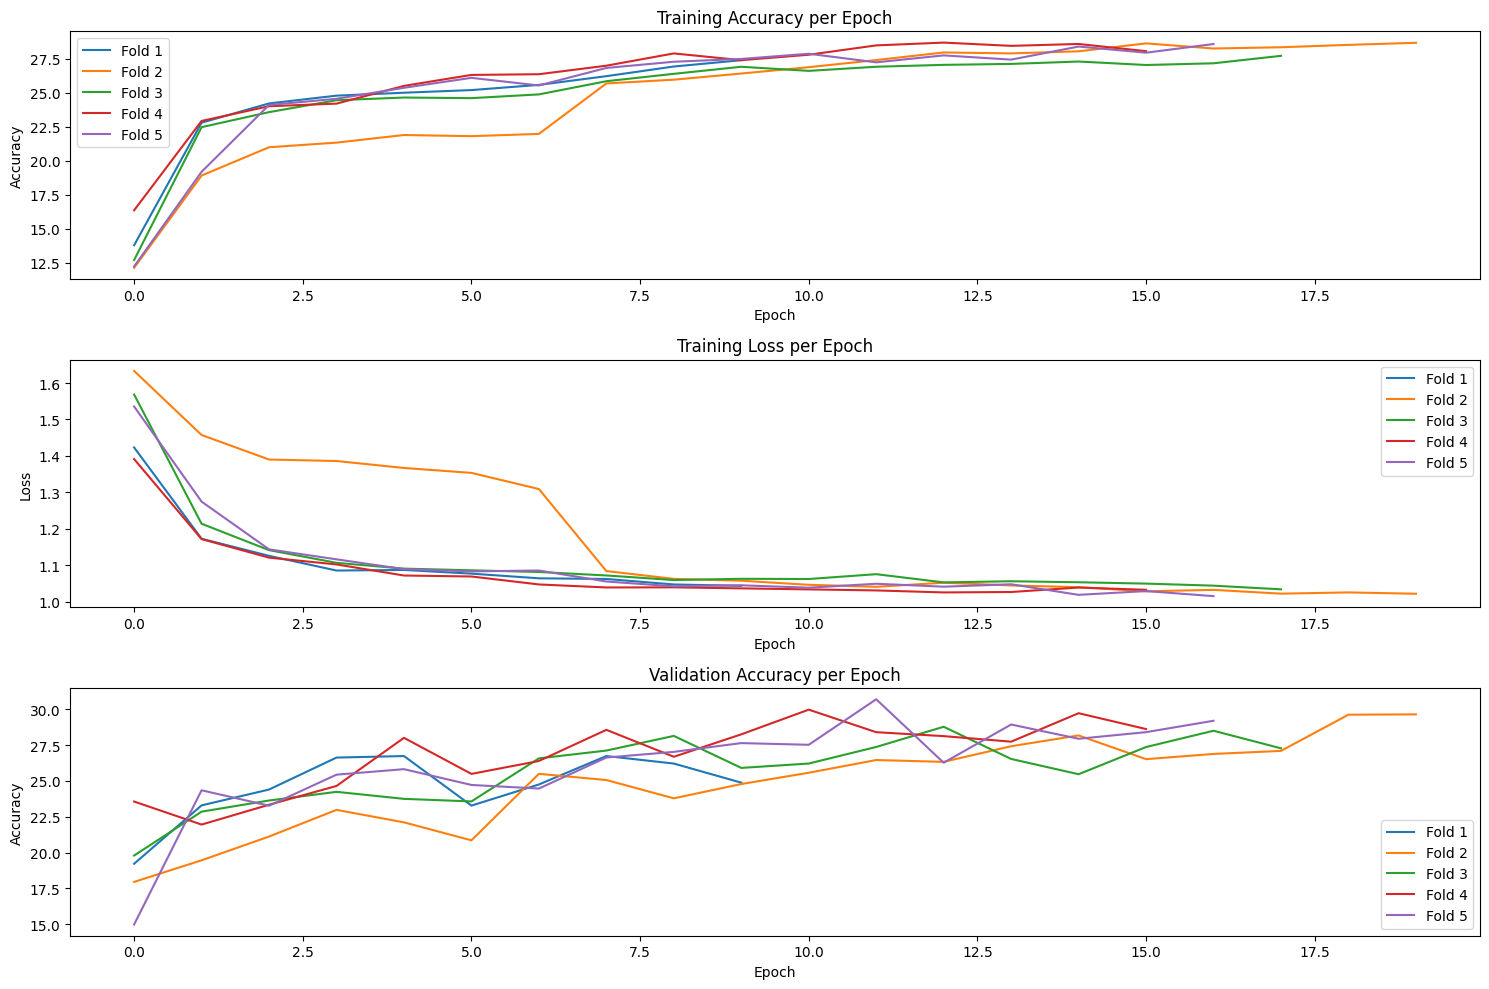

In [25]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot training accuracy
plt.subplot(3, 1, 1)
for fold in results['folds']:
    plt.plot(results['folds'][fold]['train_acc'], label=f'Fold {fold}')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(3, 1, 2)
for fold in results['folds']:
    plt.plot(results['folds'][fold]['train_loss'], label=f'Fold {fold}')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(3, 1, 3)
for fold in results['folds']:
    plt.plot(results['folds'][fold]['val_acc'], label=f'Fold {fold}')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load Best Model
cnn_model.load_state_dict(torch.load(cnn_save_path))

In [26]:
def evaluate_model(model, test_loader, device, verbose=True, accuracy_fn=mean_iou):
    """
    Evaluate the model on the test dataset.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to run the evaluation on (e.g., 'cuda' or 'cpu').
        verbose (bool): If True, print evaluation results.
        accuracy_fn (function): Function to compute accuracy (default is mean_iou).

    Returns:
        dict: A dictionary containing evaluation results.
    """
    model.eval()  # Set the model to evaluation mode
    total_test, correct_test = 0, 0
    test_results = {'test_acc': 0.0}

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_acc = accuracy_fn(outputs, labels)
            correct_test += test_acc.item() * labels.size(0)
            total_test += labels.size(0)

    test_acc = 100 * correct_test / total_test
    test_results['test_acc'] = test_acc

    if verbose:
        print(f'Test Accuracy: {test_acc:.2f}%')

    return test_results

# Load Dataset
test_dataset = GeoTiffDataset(test_data_dir, default_image=default_image, transform=transform,sample_size=None)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Final evaluation
final_acc_p4 = evaluate_model(
    model=cnn_model,
    test_loader=test_dataloader,
    device=device,
    verbose=True
)

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-9-132741d1706b>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)  # .permute(2, 0, 1)  # (H, W, C) → (C, H, W)
                                                           

Test Accuracy: 29.36%


In [ ]:
encoder_decoder_model= EncoderDecoder(input_shape=input_shape,filter_sizes=encoder_decoder_filter_sizes,decode=True)

print("encoder_decoder_model")
output=encoder_decoder_model(torch.randn(input_shape).to(device))
print(output.shape)
encoder_decoder_model.unhook()

In [ ]:
encoder_decoder_model=encoder_decoder_model.to(device)

In [ ]:


# Save the trained model
torch.save(model.state_dict(), 'cnn_model_final.pth')
print("Trained model saved as 'cnn_model_final.pth'")